/tmp/ipython-input-3454205904.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['week'] = pd.to_datetime(df['week'])
/tmp/ipython-input-3454205904.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


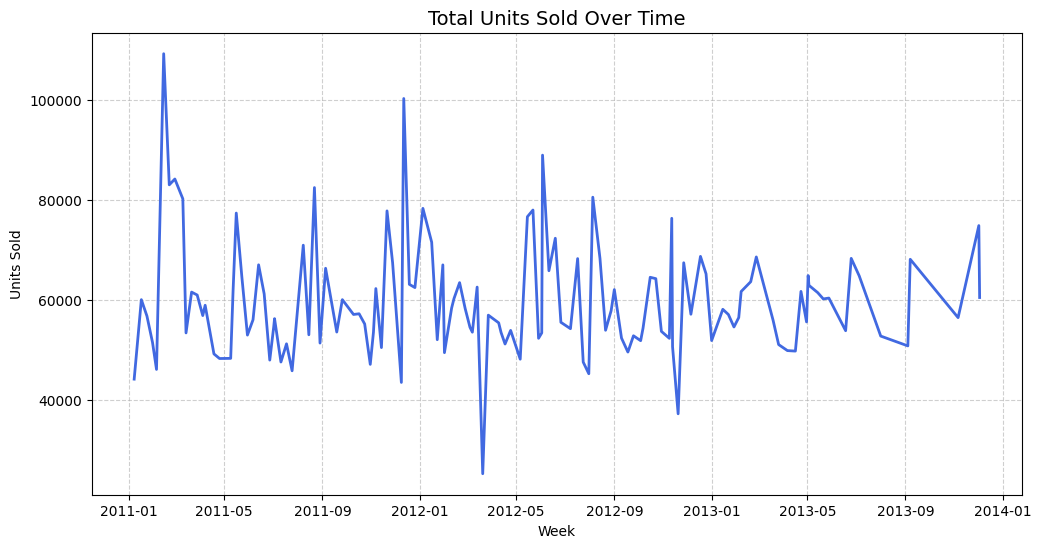

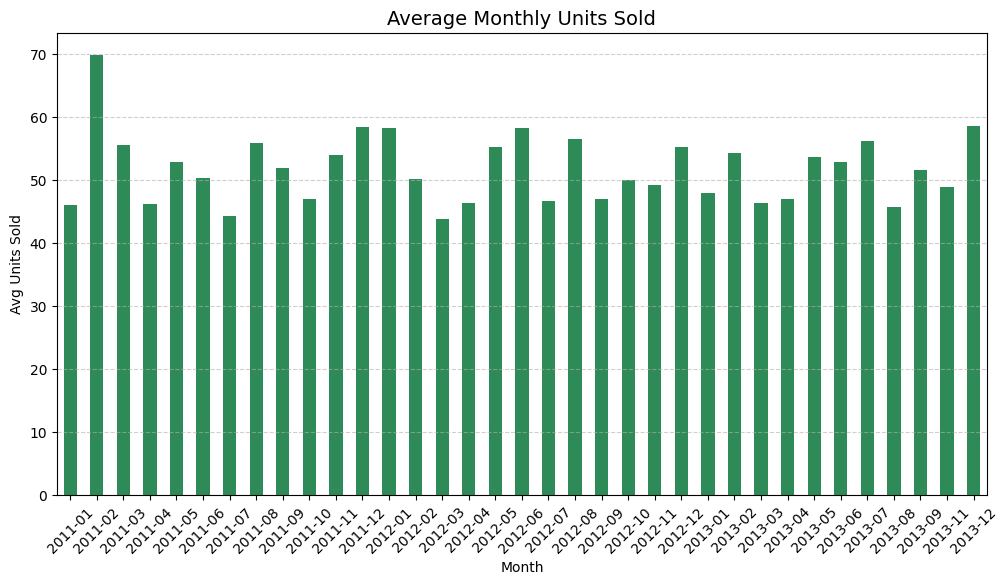

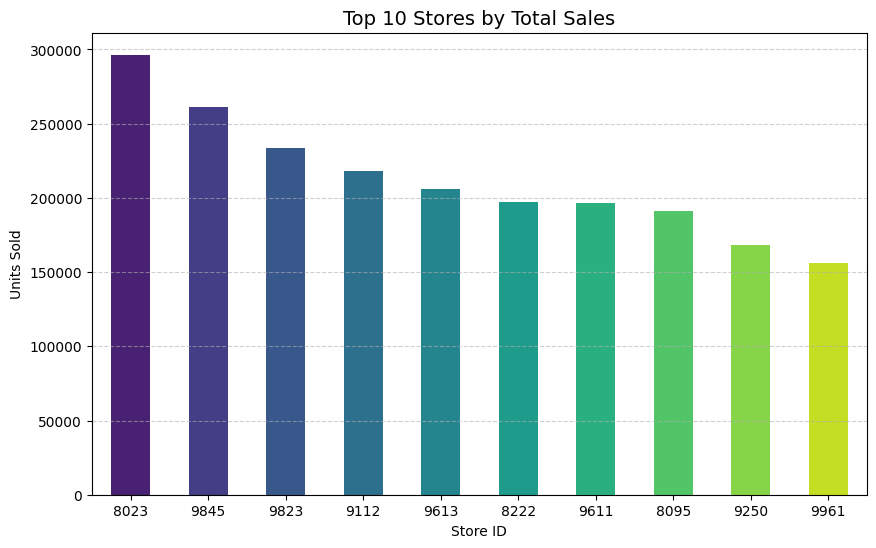

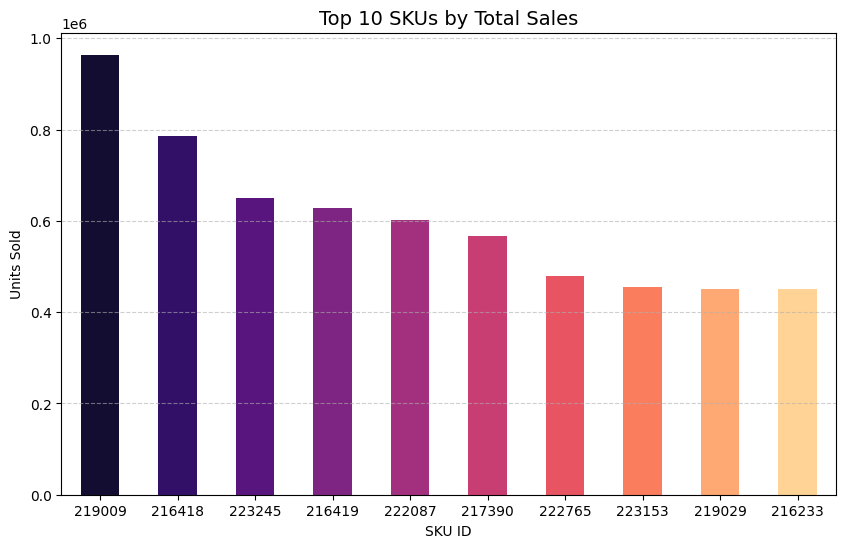

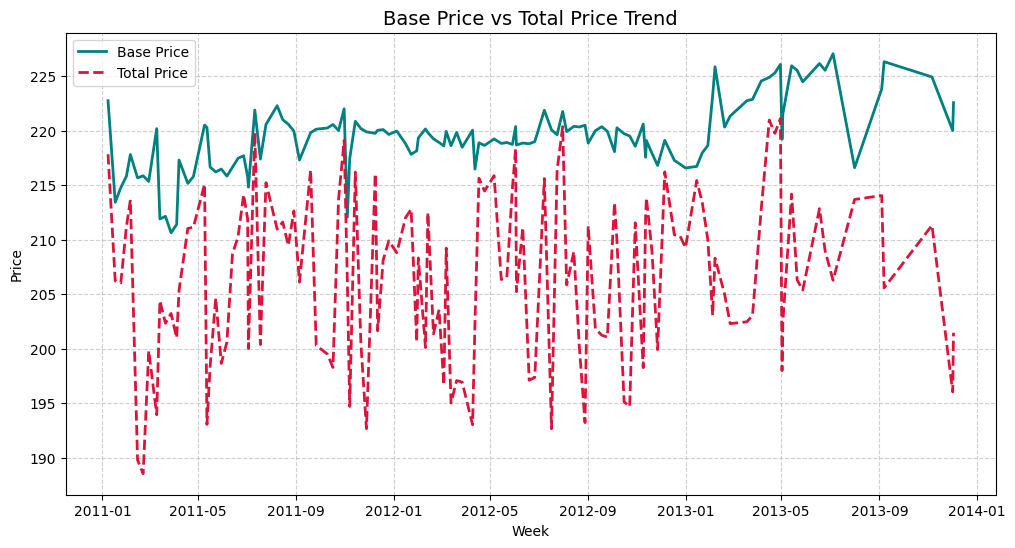


Shape of df_ml before train-test split:
(127, 8)

Head of df_ml before train-test split:


,week,units_sold,base_price,total_price,sku_id,lag_1,lag_2,lag_3
3,2011-01-31,51467,215.833214,211.193019,28,56752.0,60029.0,44134.0
4,2011-02-05,46077,217.827597,213.663019,28,51467.0,56752.0,60029.0
5,2011-02-14,109207,215.681461,189.787175,28,46077.0,51467.0,56752.0
6,2011-02-21,82986,215.876396,188.531201,28,109207.0,46077.0,51467.0
7,2011-02-28,84153,215.355130,199.825097,28,82986.0,109207.0,46077.0


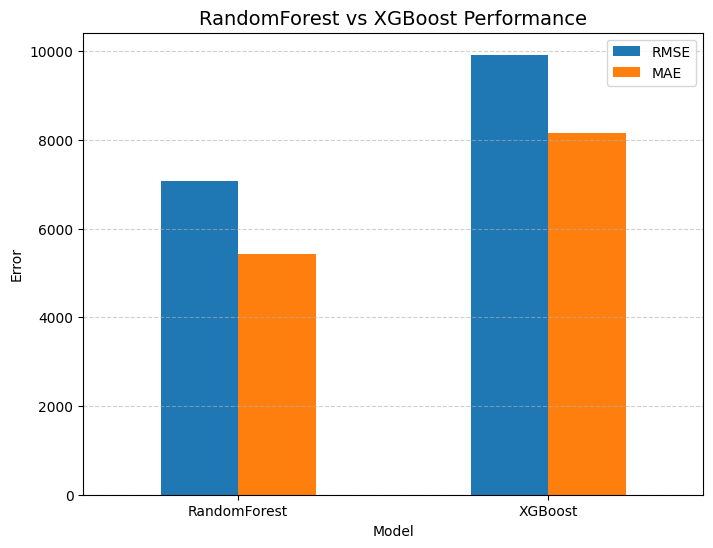

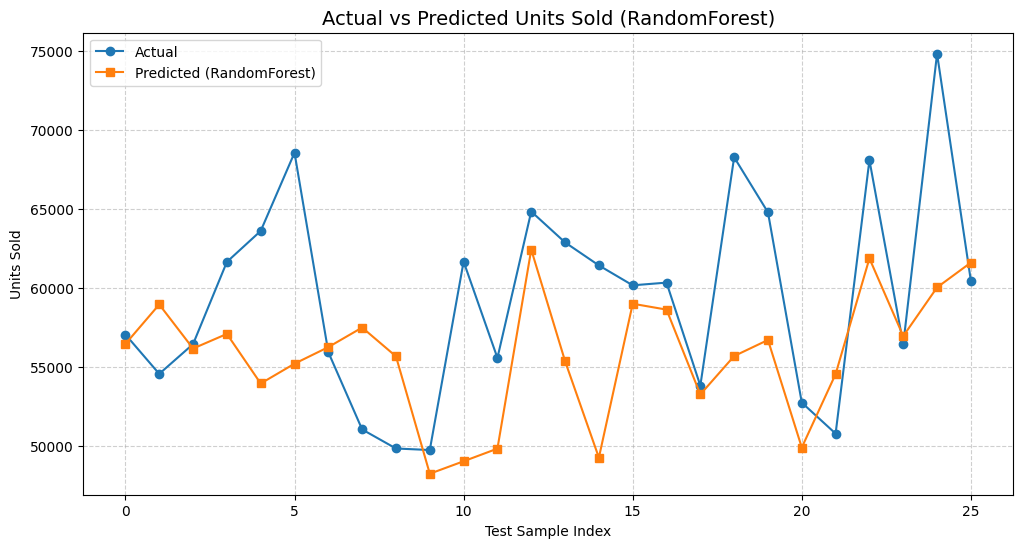

Model Comparison:
           Model         RMSE          MAE
0  RandomForest  7081.338592  5418.058269
1       XGBoost  9921.017287  8148.846191

Best Model: RandomForest


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv("/content/drive/MyDrive/inv.csv")
df['week'] = pd.to_datetime(df['week'])

for col in df.select_dtypes(include=np.number).columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].mean(), inplace=True)

df = df.drop(['record_ID','is_featured_sku','is_display_sku'], axis=1, errors="ignore")

plt.figure(figsize=(12,6))
weekly_sales = df.groupby("week")["units_sold"].sum()
plt.plot(weekly_sales.index, weekly_sales.values, color="royalblue", linewidth=2)
plt.title("Total Units Sold Over Time", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Units Sold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

df["month"] = df["week"].dt.to_period("M")
monthly_sales = df.groupby("month")["units_sold"].mean()

plt.figure(figsize=(12,6))
monthly_sales.plot(kind="bar", color="seagreen")
plt.title("Average Monthly Units Sold", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Avg Units Sold")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

store_sales = df.groupby("store_id")["units_sold"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
colors = sns.color_palette("viridis", len(store_sales))
store_sales.plot(kind="bar", color=colors)
plt.title("Top 10 Stores by Total Sales", fontsize=14)
plt.xlabel("Store ID")
plt.ylabel("Units Sold")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

sku_sales = df.groupby("sku_id")["units_sold"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
colors = sns.color_palette("magma", len(sku_sales))
sku_sales.plot(kind="bar", color=colors)
plt.title("Top 10 SKUs by Total Sales", fontsize=14)
plt.xlabel("SKU ID")
plt.ylabel("Units Sold")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

price_trend = df.groupby("week")[["base_price","total_price"]].mean()

plt.figure(figsize=(12,6))
plt.plot(price_trend.index, price_trend["base_price"], label="Base Price", color="teal", linewidth=2)
plt.plot(price_trend.index, price_trend["total_price"], label="Total Price", color="crimson", linewidth=2, linestyle="--")
plt.title("Base Price vs Total Price Trend", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

df_ml = df.groupby("week").agg({
    'units_sold':'sum',
    'base_price':'mean',
    'total_price':'mean',
    'sku_id':'nunique'
}).reset_index()

df_ml['lag_1'] = df_ml['units_sold'].shift(1)
df_ml['lag_2'] = df_ml['units_sold'].shift(2)
df_ml['lag_3'] = df_ml['units_sold'].shift(3)
df_ml = df_ml.dropna()

print("\nShape of df_ml before train-test split:")
print(df_ml.shape)
print("\nHead of df_ml before train-test split:")
display(df_ml.head())

X = df_ml[['base_price','total_price','sku_id','lag_1','lag_2','lag_3']]
y = df_ml['units_sold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
xgb_pred = xgb.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

metrics = pd.DataFrame({
    'Model':['RandomForest','XGBoost'],
    'RMSE':[rf_rmse, xgb_rmse],
    'MAE':[rf_mae, xgb_mae]
})

metrics.set_index('Model')[['RMSE','MAE']].plot(kind='bar', figsize=(8,6), color=['#1f77b4','#ff7f0e'])
plt.title("RandomForest vs XGBoost Performance", fontsize=14)
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

best_model = "RandomForest" if rf_rmse < xgb_rmse else "XGBoost"
best_pred = rf_pred if rf_rmse < xgb_rmse else xgb_pred

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual", marker="o")
plt.plot(best_pred, label=f"Predicted ({best_model})", marker="s")
plt.title(f"Actual vs Predicted Units Sold ({best_model})", fontsize=14)
plt.xlabel("Test Sample Index")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

print("Model Comparison:\n", metrics)
print(f"\nBest Model: {best_model}")
